In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

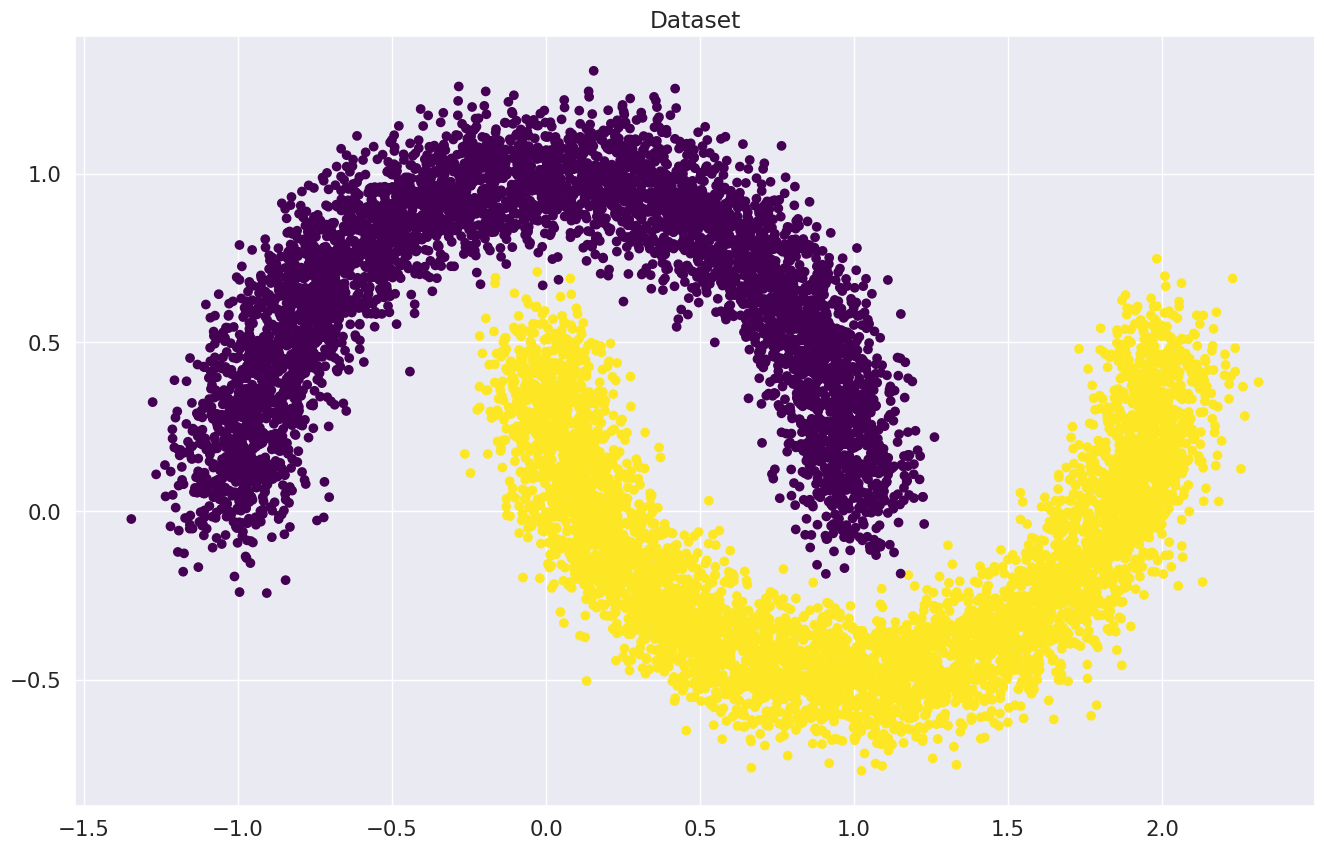

In [ ]:
X, y = make_moons(n_samples = 10000, random_state = 42, noise = 0.1)
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [ ]:
X_train_t =  torch.from_numpy(X_train.astype('float32'))
y_train_t =  torch.from_numpy(y_train.astype('float32'))
X_val_t =  torch.from_numpy(X_val.astype('float32'))
y_val_t =  torch.from_numpy(y_val.astype('float32'))

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size = 128)
val_dataloader = DataLoader(val_dataset, batch_size = 128)

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
    self.bias = bias
    if bias:
      self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True))


  def forward(self, x):
    x = x @ self.weights

    if self.bias:
      x += self.bias_term

    return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp.view(-1), y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.828125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


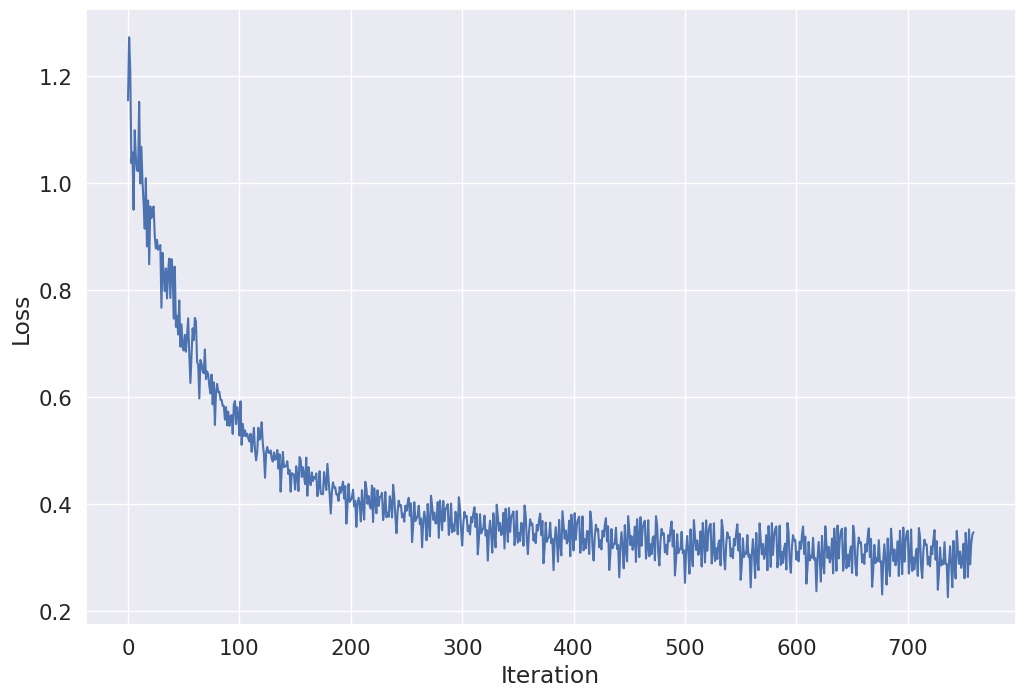

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

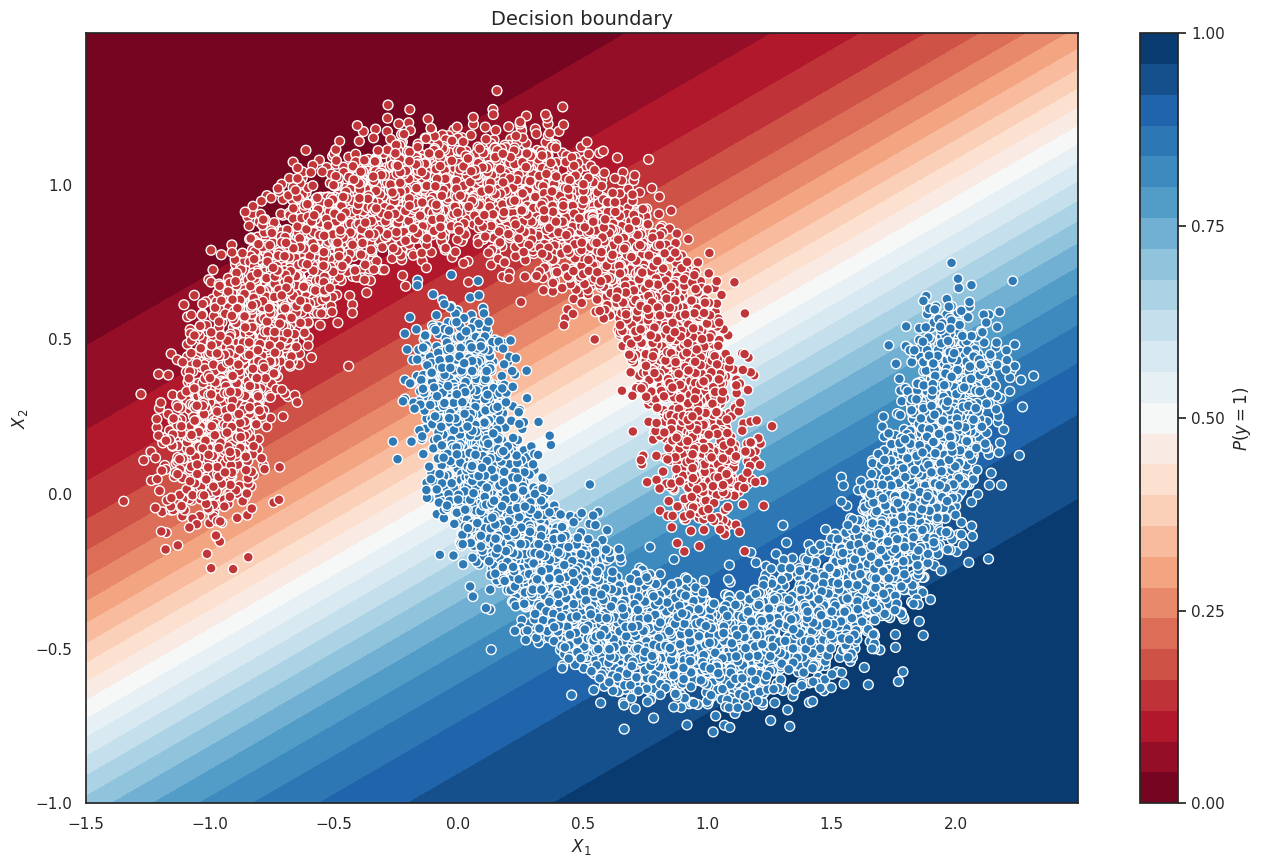

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    y_true = np.array([])
    predictions = np.array([])
    for it, (X_batch, y_batch) in enumerate(dataloader):
        probabilities = torch.sigmoid(model.forward(X_batch)) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        y_true =  np.hstack((y_true, np.array(y_batch)))
    return (predictions.flatten(), y_true)

In [ ]:
from sklearn.metrics import accuracy_score

(y_pred, y_true) = predict(val_dataloader, linear_regression)
print(accuracy_score(y_true, y_pred))

0.8648


In [ ]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle=True, num_workers=2)

In [ ]:
activation = nn.ELU
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = torch.softmax(model(x_batch), dim=1)

            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9075333333333333
Loader: valid. Accuracy: 0.9476
Epoch: 2
Loader: train. Accuracy: 0.9474333333333333
Loader: valid. Accuracy: 0.9553
Epoch: 3
Loader: train. Accuracy: 0.9558833333333333
Loader: valid. Accuracy: 0.9629
Epoch: 4
Loader: train. Accuracy: 0.95875
Loader: valid. Accuracy: 0.9505
Epoch: 5
Loader: train. Accuracy: 0.9622833333333334
Loader: valid. Accuracy: 0.9544
Epoch: 6
Loader: train. Accuracy: 0.9653
Loader: valid. Accuracy: 0.9624
Epoch: 7
Loader: train. Accuracy: 0.9665333333333334
Loader: valid. Accuracy: 0.9549
Epoch: 8
Loader: train. Accuracy: 0.96755
Loader: valid. Accuracy: 0.963
Epoch: 9
Loader: train. Accuracy: 0.9687333333333333
Loader: valid. Accuracy: 0.9496
Epoch: 10
Loader: train. Accuracy: 0.9699333333333333
Loader: valid. Accuracy: 0.9614
